In [809]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam, SGD
from keras import regularizers
from keras.callbacks import Callback, LearningRateScheduler
from keras import backend as K

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import KFold, GridSearchCV

In [763]:
folder = "without_na"

train = pd.read_csv("{}/train_clean.csv".format(folder))
val = pd.read_csv("{}/validation_clean.csv".format(folder))

In [764]:
features_to_drop = ['objid', 'class']

X_train = train.drop(features_to_drop, axis=1).values
y_train = train['class'].values
y_train = to_categorical(y_train, num_classes=3)
    
X_test = val.drop(features_to_drop, axis=1).values
y_test = val['class'].values
y_test = to_categorical(y_test, num_classes=3)


scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)    

In [765]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))  

In [766]:
def get_class_weights(labels):
    classes, class_counts = np.unique(labels, return_counts=True)
    weights = 1 - class_counts / np.sum(class_counts)
    return {c:w for c, w in zip(classes, weights)}

In [1017]:
# update learning rate every 5 epochs
def get_lr(epoch):
    initial_lr = 0.01
    l_rate = initial_lr * np.power(0.5, epoch // 5)
    return l_rate
lrate = LearningRateScheduler(get_lr)

In [1051]:
model = Sequential()

model.add(Dense(35, input_dim=39, activation='relu', kernel_regularizer=regularizers.l1(0.001)))
model.add(Dropout(0.3))

model.add(Dense(25, activation='relu', kernel_regularizer=regularizers.l1(0.003)))
model.add(Dropout(0.3))

model.add(Dense(15, activation='relu', kernel_regularizer=regularizers.l1(0.003)))
model.add(Dropout(0.3))


model.add(Dense(3, activation='softmax'))

In [1052]:
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=[f1])

history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=1024,
                    validation_data=[X_test, y_test],
                    class_weight=get_class_weights(val['class']),
                    callbacks=[lrate])

Train on 30000 samples, validate on 23333 samples
Epoch 1/20
30000/30000 [==============================] - 19s 621us/step - loss: 1.0962 - f1: 0.1104 - val_loss: 1.2315 - val_f1: 0.1709
Epoch 2/20
30000/30000 [==============================] - 1s 40us/step - loss: 0.7122 - f1: 0.3988 - val_loss: 0.9677 - val_f1: 0.5873
Epoch 3/20
30000/30000 [==============================] - 1s 42us/step - loss: 0.6506 - f1: 0.4979 - val_loss: 0.9507 - val_f1: 0.6174
Epoch 4/20
30000/30000 [==============================] - 1s 41us/step - loss: 0.6335 - f1: 0.5333 - val_loss: 0.9117 - val_f1: 0.5898
Epoch 5/20
30000/30000 [==============================] - 1s 40us/step - loss: 0.6263 - f1: 0.5575 - val_loss: 0.9290 - val_f1: 0.6159
Epoch 6/20
30000/30000 [==============================] - 1s 40us/step - loss: 0.6188 - f1: 0.5623 - val_loss: 0.9111 - val_f1: 0.6461
Epoch 7/20
30000/30000 [==============================] - 1s 40us/step - loss: 0.6146 - f1: 0.5693 - val_loss: 0.9682 - val_f1: 0.6045
Epo

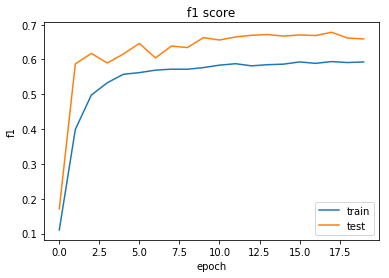

In [1053]:
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.legend(['train', 'test'], loc='lower right')
plt.title('f1 score')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.show()

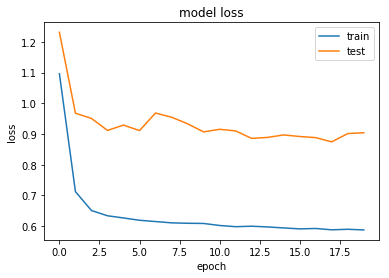

In [1054]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'test'], loc='upper right')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [1050]:
predictions_p = model.predict(X_test)
predictions = np.argmax(predictions_p, axis=1)
true_labels = np.argmax(y_test, axis=1)
f1_score(true_labels, predictions, average='macro')

0.7620110529568952

In [978]:
history = model.fit(X_train, y_train,
                    epochs=3,
                    batch_size=128,
                    validation_data=[X_test, y_test],
                    class_weight=get_class_weights(val['class']))

Train on 30000 samples, validate on 23333 samples
Epoch 1/3
30000/30000 [==============================] - 4s 132us/step - loss: 0.5206 - f1: 0.7054 - val_loss: 0.7897 - val_f1: 0.6925
Epoch 2/3
30000/30000 [==============================] - 3s 110us/step - loss: 0.5167 - f1: 0.7120 - val_loss: 0.7243 - val_f1: 0.7178
Epoch 3/3
30000/30000 [==============================] - 3s 109us/step - loss: 0.5080 - f1: 0.7185 - val_loss: 0.7340 - val_f1: 0.7239


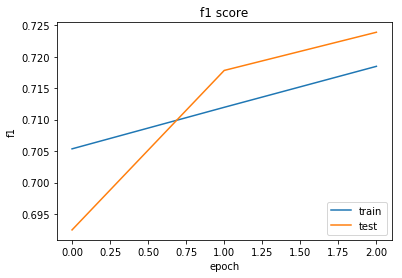

In [979]:
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.legend(['train', 'test'], loc='lower right')
plt.title('f1 score')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.show()

In [980]:
predictions_p = model.predict(X_test)
predictions = np.argmax(predictions_p, axis=1)
true_labels = np.argmax(y_test, axis=1)
f1_score(true_labels, predictions, average='macro')

0.7100634980135125